In [6]:
# Standard library imports
import os

# Third-party imports for data manipulation and analysis
import pandas as pd
import numpy as np

# PyTorch and related libraries for deep learning
import torch
from torch import nn, save, load
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision.models import ResNet18_Weights
import torchvision

# Libraries for audio processing
import torchaudio
import librosa
import librosa.display
from scipy.io import wavfile
from scipy import signal

# Libraries for image processing
from PIL import Image

# Libraries for model training and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Libraries for progress tracking and visualization
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


# Hyper parameters

In [7]:
DPI=100
figuresize=(2.24,2.24)
img_size=(224,224)
hop_length=1
n_fft = 2048 
sr=8000
repeat=2
Batch_size=10
learn_rate=0.001
Momentum=0.9
num_epochs=1
patience=3
num_classes = 2

In [8]:
class MyDataset:
    def __init__(self, list_of_audio_files, labels, transform=None):
        self.list_of_audio_files = list_of_audio_files
        self.transform = transform
        self.labels = labels

    def __len__(self):
        return len(self.list_of_audio_files)

    def __getitem__(self, idx):
        audio_file = os.path.join("/kaggle/input/spr-splitevents", self.list_of_audio_files[idx])
        samples, sample_rate = librosa.load(audio_file, sr=None)
        spectrogram = librosa.stft(samples)
        spectrogram = librosa.amplitude_to_db(np.abs(spectrogram), ref=np.max)
        
        # Convert the spectrogram to an image
        fig, ax = plt.subplots(1, 1, figsize=figuresize, dpi=DPI)
        ax.axis('off')
        img = librosa.display.specshow(spectrogram, ax=ax, cmap='gray')
        fig.savefig('spectrogram.png', bbox_inches='tight', pad_inches=0)
        plt.close(fig)
        img = Image.open('spectrogram.png').convert('RGB')
        img = img.resize(img_size)  # Resize the image to 224x224 pixels
        img = np.array(img)
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label


In [9]:
def calculate_accuracy(loader, model):
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    all_probs = []  # Store predicted probabilities
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probs.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())  # Get probabilities for class 1
    return 100 * correct / total, np.array(all_labels), np.array(all_predictions), np.array(all_probs)

In [95]:
def plot_metrics(acc, labels, preds, prob):
    cm = confusion_matrix(labels, preds)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Compute ROC curve
    fpr, tpr, threshold = roc_curve(labels, prob)
    roc_auc = roc_auc_score(labels, prob)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})', linewidth=5)
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlim([0.0, 1.0])  # Set x limits
    plt.ylim([0.0, 1.0])  # Set y limits
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

    # Calculate sensitivity and specificity
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    print(f'Sensitivity (Recall): {sensitivity:.2f}')
    print(f'Specificity: {specificity:.2f}')

    # Printing the classification report
    print(classification_report(labels, preds, target_names=['normal', 'abnormal']))

In [20]:
df =pd.read_csv("/kaggle/input/spr-splitevents/events_processed (1).csv")
# df =df.reset_index(drop=True)
train_val, test = train_test_split(df, test_size=0.1, random_state=42, stratify=df["type"])
train,val = train_test_split(train_val, test_size=0.1, random_state=42, stratify=train_val["type"])
train =train.reset_index(drop=True)
val =val.reset_index(drop=True)
test =test.reset_index(drop=True)

In [21]:
trainset = MyDataset(train["event_path"],train["type"],transform=torchvision.transforms.ToTensor())
valset = MyDataset(val["event_path"],val["type"],transform=torchvision.transforms.ToTensor())
testset= MyDataset(test["event_path"],test["type"],transform=torchvision.transforms.ToTensor())
trainloader = DataLoader(trainset, batch_size=Batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size=Batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=Batch_size, shuffle=True)

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# RESNET 18

In [22]:
# Load the pre-trained ResNet18 model from torchvision
resnet18 = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

resnet18.fc = torch.nn.Linear(resnet18.fc.in_features, num_classes)

# Define a loss function and an optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet18.parameters(), lr=learn_rate, momentum=Momentum)

# Move the model to the GPU if available

resnet18 = resnet18.to(device)

# Define the path to save the best model
best_model_path = "res18stftbest_model.pt"
# Initialize the best validation accuracy
best_val_acc = 0
# Training and validation
restrain_accuracies = []
resval_accuracies = []
patience_counter = 0

In [97]:
resnet18 = resnet18.to(device)

In [32]:
# Initialize the early_stopping_monitor
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    correct = 0
    total = 0
    # Training phase
    resnet18.train()
    loop = tqdm(trainloader, leave=True)
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Update progress bar
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        loop.set_postfix(loss=loss.item())
    # Print accuracy after each epoch
    train_acc = 100 * correct / total
    restrain_accuracies.append(accuracy)
    val_acc, val_labels, val_preds,val_probs = calculate_accuracy(valloader, resnet18)
    resval_accuracies.append(val_acc)
    print(f'Train Accuracy: {train_acc}%, Validation Accuracy: {val_acc}%')

    # Save the model if it has the best validation accuracy so far
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(resnet18.state_dict(), best_model_path)
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping")
        break

Epoch 1/1


100%|██████████| 465/465 [08:58<00:00,  1.16s/it, loss=0.408] 


Train Accuracy: 85.72351421188631%, Validation Accuracy: 81.5891472868217%


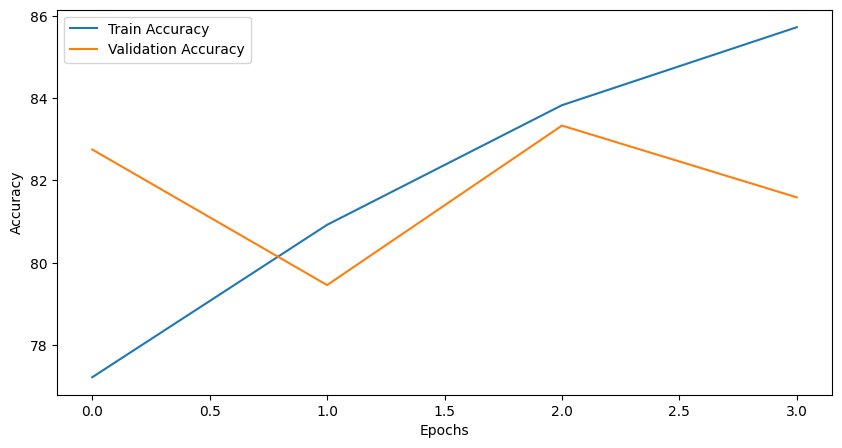

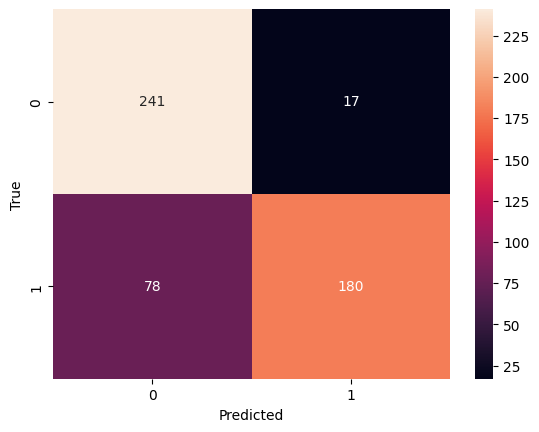

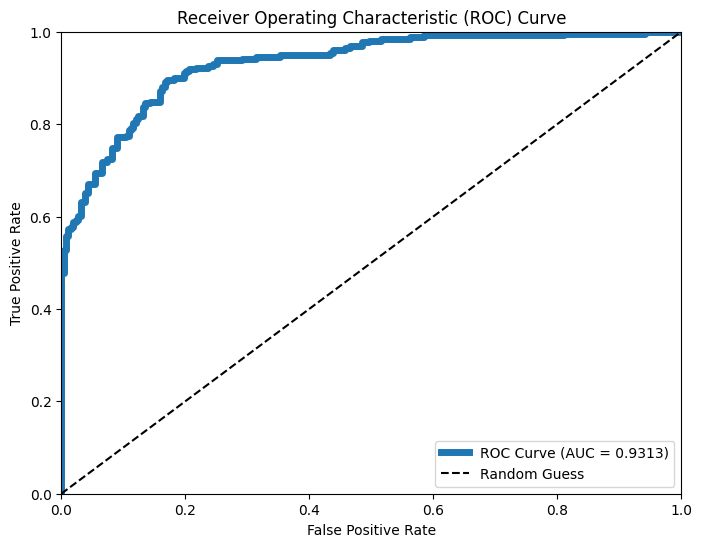

              precision    recall  f1-score   support

      normal       0.76      0.93      0.84       258
    ubnormal       0.91      0.70      0.79       258

    accuracy                           0.82       516
   macro avg       0.83      0.82      0.81       516
weighted avg       0.83      0.82      0.81       516



In [35]:
# Plotting the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plot_metrics(val_acc, val_labels, val_preds,val_probs)

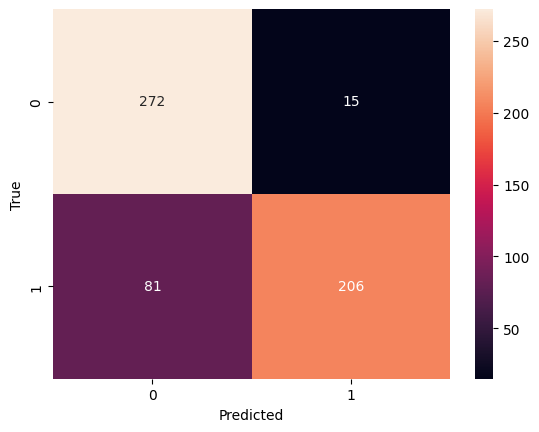

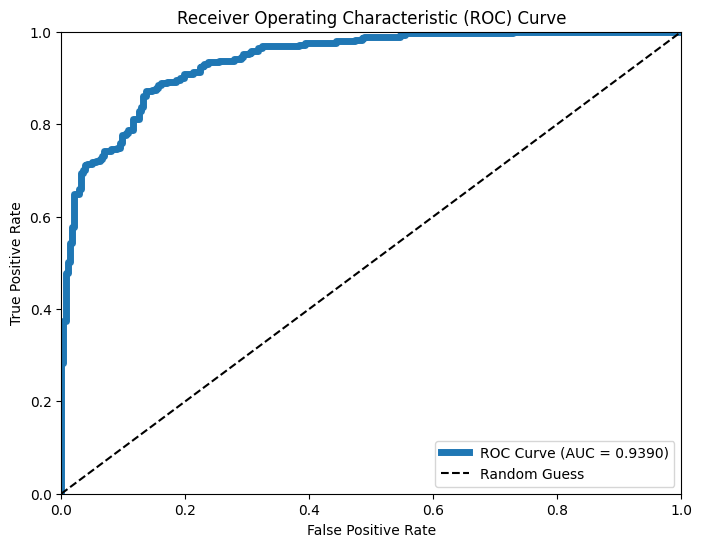

Sensitivity (Recall): 0.72
Specificity: 0.95
              precision    recall  f1-score   support

      normal       0.77      0.95      0.85       287
    abnormal       0.93      0.72      0.81       287

    accuracy                           0.83       574
   macro avg       0.85      0.83      0.83       574
weighted avg       0.85      0.83      0.83       574



In [98]:
#testing
test_acc, test_labels, test_preds,test_prob = calculate_accuracy(testloader, resnet18)
plot_metrics(test_acc, test_labels, test_preds,test_prob)

In [73]:
    with open('5epoch0.9s100bvgg.pt', 'wb') as f: 
        save(vgg16.state_dict(), f) 

# best run for resnet 18

In [99]:
num_classes = 2  # The number of output features in the model from the checkpoint
resnet = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

resnet.fc = torch.nn.Linear(resnet18.fc.in_features, num_classes)
resnet = resnet.to(device)

with open('/kaggle/input/spr-splitevents/resnetbeststft.pt', 'rb') as f: 
    resnet.load_state_dict(torch.load(f))


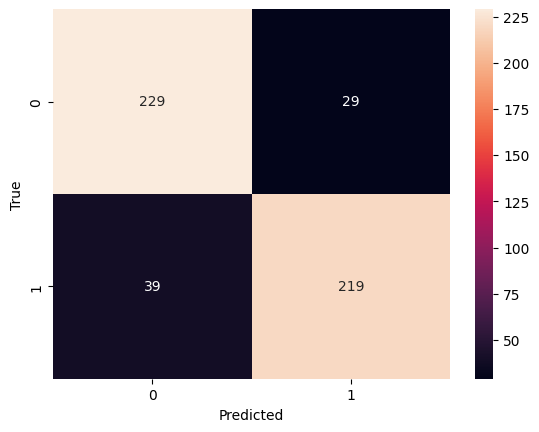

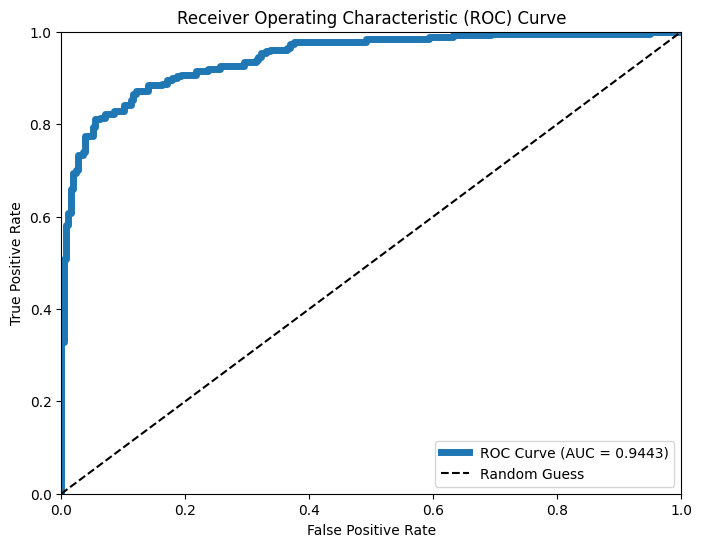

              precision    recall  f1-score   support

      normal       0.85      0.89      0.87       258
    ubnormal       0.88      0.85      0.87       258

    accuracy                           0.87       516
   macro avg       0.87      0.87      0.87       516
weighted avg       0.87      0.87      0.87       516



In [94]:
val_acc, val_labels, val_preds,val_probs = calculate_accuracy(valloader, vggload)

plot_metrics(val_acc, val_labels, val_preds,val_probs)

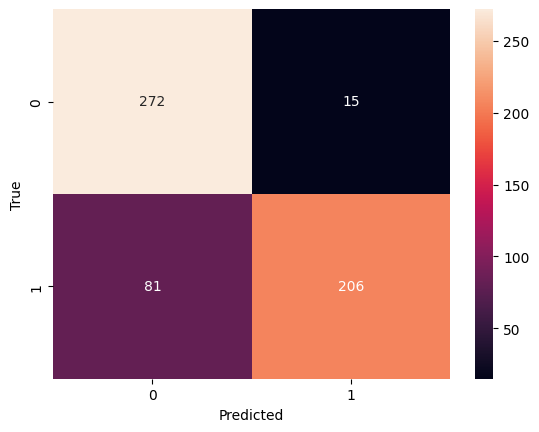

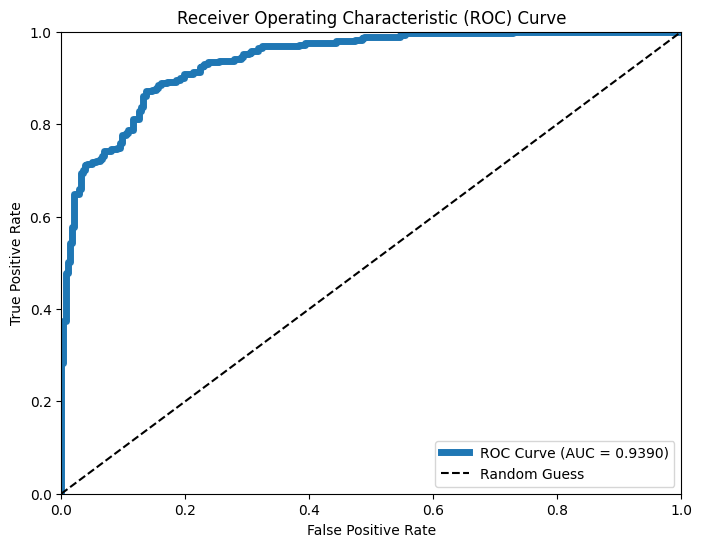

Sensitivity (Recall): 0.72
Specificity: 0.95
              precision    recall  f1-score   support

      normal       0.77      0.95      0.85       287
    abnormal       0.93      0.72      0.81       287

    accuracy                           0.83       574
   macro avg       0.85      0.83      0.83       574
weighted avg       0.85      0.83      0.83       574



In [100]:
#testing
test_acc, test_labels, test_preds,test_prob = calculate_accuracy(testloader, resnet)
plot_metrics(test_acc, test_labels, test_preds,test_prob)

# VGG 16

In [55]:
# Load the pre-trained VGG16 model from torchvision
vgg16 = models.vgg16(pretrained=True)

# Replace the last layer (classifier) to match the number of classes in your dataset
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, num_classes)

# Define a loss function and an optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vgg16.parameters(), lr=learn_rate, momentum=Momentum)

# Move the model to the GPU if available

vgg16 = vgg16.to(device)
# Define the path to save the best model
best_model_path = "vggstftbest_model.pt"
# Initialize the best validation accuracy
best_val_acc = 0
# Training and validation
vgg16train_accuracies = []
vgg16val_accuracies = []
patience_counter=0

In [80]:
vgg16 = vgg16.to(device)


In [68]:
# Initialize the early_stopping_monitor
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    correct = 0
    total = 0
    # Training phase
    vgg16.train()
    loop = tqdm(trainloader, leave=True)
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Update progress bar
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        loop.set_postfix(loss=loss.item())
    # Print accuracy after each epoch
    train_acc = 100 * correct / total
    vgg16train_accuracies.append(accuracy)
    val_acc, val_labels, val_preds,val_probs = calculate_accuracy(valloader, vgg16)
    vgg16val_accuracies.append(val_acc)
    print(f'Train Accuracy: {train_acc}%, Validation Accuracy: {val_acc}%')

    # Save the model if it has the best validation accuracy so far
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(vgg16.state_dict(), best_model_path)
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping")
        break

Epoch 1/1


100%|██████████| 465/465 [09:19<00:00,  1.20s/it, loss=0.117]  


Train Accuracy: 88.82428940568475%, Validation Accuracy: 84.68992248062015%


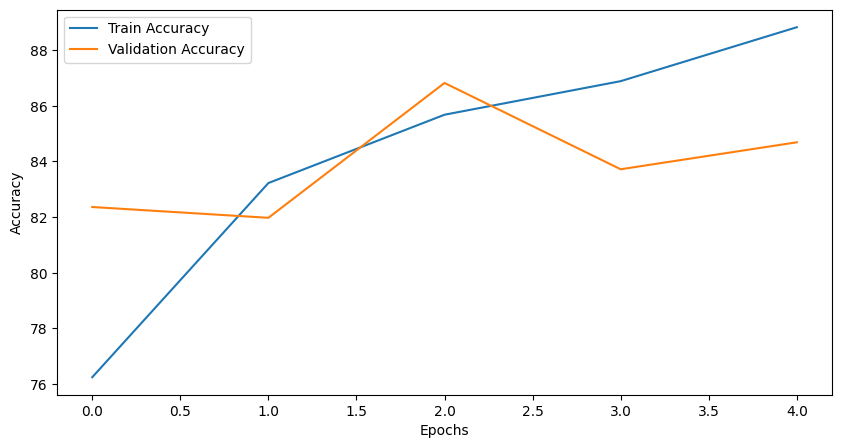

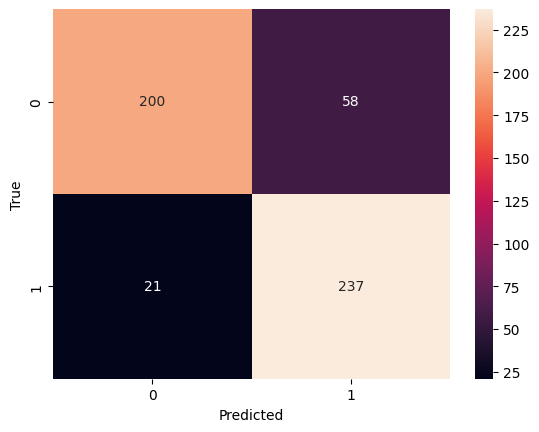

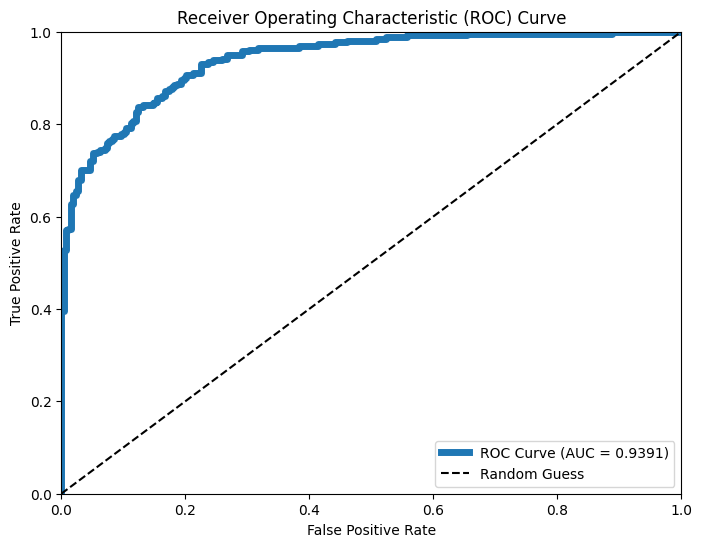

              precision    recall  f1-score   support

      normal       0.90      0.78      0.84       258
    ubnormal       0.80      0.92      0.86       258

    accuracy                           0.85       516
   macro avg       0.85      0.85      0.85       516
weighted avg       0.85      0.85      0.85       516



In [69]:
plt.figure(figsize=(10, 5))
plt.plot(vgg16train_accuracies, label='Train Accuracy')
plt.plot(vgg16val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


plot_metrics(val_acc, val_labels, val_preds,val_probs)

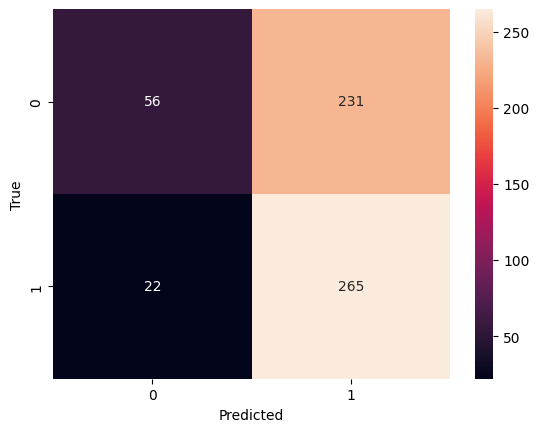

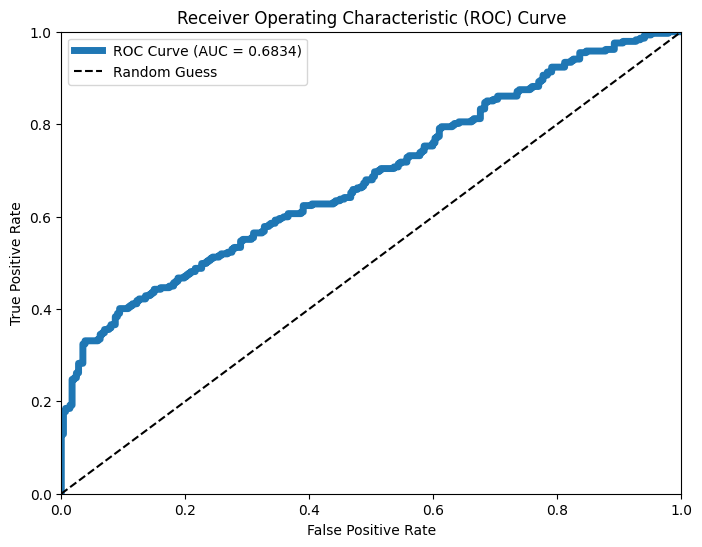

              precision    recall  f1-score   support

      normal       0.72      0.20      0.31       287
    ubnormal       0.53      0.92      0.68       287

    accuracy                           0.56       574
   macro avg       0.63      0.56      0.49       574
weighted avg       0.63      0.56      0.49       574



In [81]:
#testing
test_acc, test_labels, test_preds,test_prob = calculate_accuracy(testloader, vgg16)
plot_metrics(test_acc, test_labels, test_preds,test_prob)

# best run vgg 16

In [101]:
num_classes = 2  # The number of output features in the model from the checkpoint
vggload = models.vgg16(pretrained=True)

vggload.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, num_classes)
vggload = vggload.to(device)

with open('/kaggle/input/spr-splitevents/vggbeststft.pt', 'rb') as f: 
    vggload.load_state_dict(torch.load(f))


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


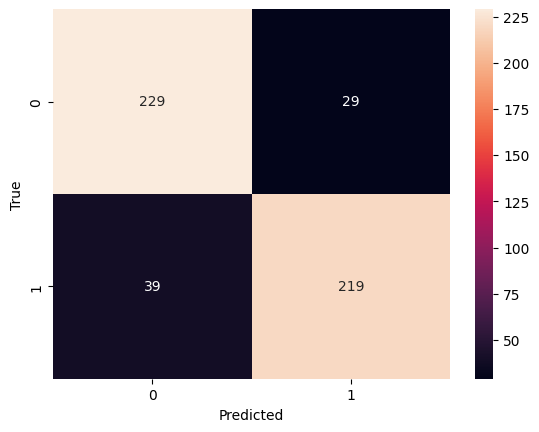

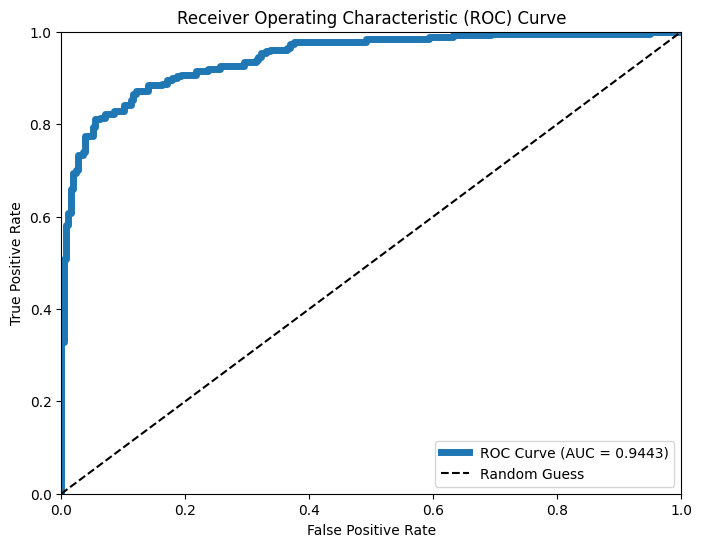

Sensitivity (Recall): 0.85
Specificity: 0.89
              precision    recall  f1-score   support

      normal       0.85      0.89      0.87       258
    abnormal       0.88      0.85      0.87       258

    accuracy                           0.87       516
   macro avg       0.87      0.87      0.87       516
weighted avg       0.87      0.87      0.87       516



In [102]:
val_acc, val_labels, val_preds,val_probs = calculate_accuracy(valloader, vggload)

plot_metrics(val_acc, val_labels, val_preds,val_probs)

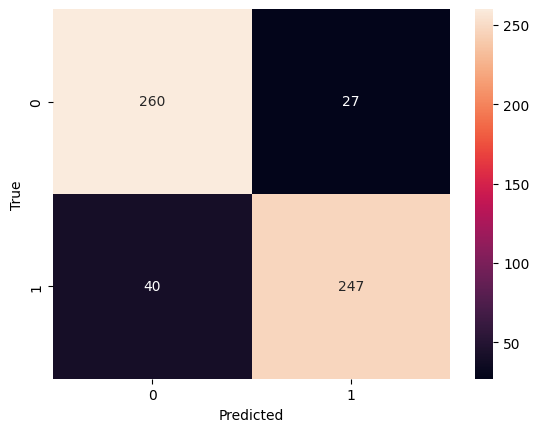

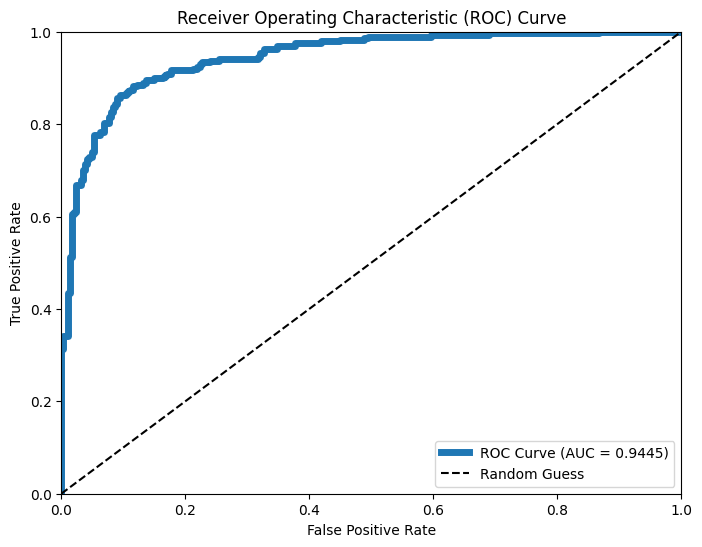

Sensitivity (Recall): 0.86
Specificity: 0.91
              precision    recall  f1-score   support

      normal       0.87      0.91      0.89       287
    abnormal       0.90      0.86      0.88       287

    accuracy                           0.88       574
   macro avg       0.88      0.88      0.88       574
weighted avg       0.88      0.88      0.88       574



In [103]:
#testing
test_acc, test_labels, test_preds,test_prob = calculate_accuracy(testloader, vggload)
plot_metrics(test_acc, test_labels, test_preds,test_prob)

In [92]:
torch.save(vggload.state_dict(), "best_stftvgg.pt")